# Generating model results for Parkinson Data

In [1]:
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

/mnt/raid/data/anina/ScanDy


In [70]:
import importlib
import os
import pickle
import random

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.legend_handler import HandlerTuple

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from neurolib.optimize.evolution import Evolution
from neurolib.utils.parameterSpace import ParameterSpace

import scandy_pfc.models.ObjectModel as objectmodel_module
import scandy_pfc.models.model as base_model
import scandy_pfc.utils.dataclass as dataclass_module
import scandy_pfc.utils.functions as uf


In [75]:
#Parameters to change for each dataset
test_group = "young" #"old" "pd_on", "pd_off"
dataframe_files = {
    "young": 'df_all_fovs_psycsci.csv',
    "old": 'df_all_fovs_psycsci.csv',
    "pd_on": 'df_all_fovs_psycsci.csv',
    "pd_off": 'df_all_fovs_psycsci.csv'
}
folder_path = "/mnt/raid/data/anina/ScanDy/PictureExample/picture/"

#####
evolution_name_dill = f"saved_evolution_obj_DG2E_cb_picturedata_{test_group}.dill"
evolution_name_hdf = f"saved_evolution_obj_DG2E_cb_picturedata_{test_group}.hdf"
simulate_with_best_params = f"best_params_obj_DG2E_cb_picturedata_{test_group}"

In [72]:
dircl = ['xkcd:maroon', sns.color_palette("Dark2")[1], sns.color_palette("Dark2")[5], sns.color_palette("Dark2")[6] ]
mcl = ['xkcd:blue', 'xkcd:red']
MODEL = "obj" 
FEATURESET = "DG2E_cb" 


In [73]:
importlib.reload(dataclass_module)
Dataset = dataclass_module.Dataset
importlib.reload(base_model)
importlib.reload(objectmodel_module)
ObjectModel = objectmodel_module.ObjectModel



## Load Imagedata

In [76]:
files = [os.path.splitext(f)[0] for f in os.listdir(folder_path) 
         if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(".png")]

print(files)

['openDoorInside', 'phone', 'ballBalance', 'disinfectant', 'waterHose', 'catcafe', 'monitorLizard', 'trash', 'mokaPot', 'penDrawing', 'yoga', 'bottleString', 'robot', 'work', 'bed', 'kettle', 'bird', 'toytrain', 'giraffe', 'ventilator', 'openDoorOutside', 'shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2', 'candle', 'monkey2', 'statues', 'coffeeOnSofa', 'crow', 'blueBoiler', 'axolotl', 'rippingPaper', 'reindeers', 'billboard', 'lizard', 'plank', 'bigAnimalBackground', 'work2', 'dino', 'laundry', 'birdFalling', 'bikeUnlocking', 'heron', 'conversation', 'robot2', 'clock', 'crowBall', 'whiteBoard', 'trafficLight2', 'construction', 'gondolaUp', 'carStart', 'fingerTapping', 'chessBoard', 'stapler', 'elevatorWrongSide', 'lake', 'receipt', 'bench', 'teabagOut', 'toytrainHouses', 'sparkling2', 'espresso', 'skiLift', 'trafficLight', 'mail', 'watering', 'snip', 'selfie', 'shoot', 'throw', 'youtube']


TODO: Run again with full Imagelist, current Dataset only 11 images

PATH changable?

In [77]:
# full imagelist
# imglist = sorted(files)
imglist = sorted(['shoebill', 'fish', 'pedestrian', 'toaster', 'waterbottle', 'sealion', 'elevatorEmpty', 'watercooler', 'fly', 'chimpanzee', 'trinkvogel2'])

random.seed(12345)
#trainlist = sorted(random.sample(imglist, 10))
trainlist = sorted(random.sample(imglist, 2))
testlist = sorted([vidname for vidname in imglist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)
print(len(trainlist), len(imglist))
datadict = {
    "PATH": "PictureExample/", 
    'FPS' : 30,
    'PX_TO_DVA' : (47.7 * 0.8) / 1920,
    'FRAMES_ALL_VIDS' : 150,
    'gt_foveation_df' : gt_foveation_df,
    'dataformat': 'picture', #'video', 'both' #<-- filter for video/picture
    'NAME_COL' : 'scene', #<-- changed from 'video' to 'scene' from ScanDy to ScanDy with Pfc
    'trainset' : trainlist,
    'testset' : testlist,
    'used_videos': imglist
}
VidCom = Dataset(datadict)

# For faster processing during testing, resized the videos to smaller dimensions
VidCom.VID_SIZE_Y, VidCom.VID_SIZE_X = 540, 960

trainlist =  ['chimpanzee', 'shoebill'] 
testlist = ['elevatorEmpty', 'fish', 'fly', 'pedestrian', 'sealion', 'toaster', 'trinkvogel2', 'waterbottle', 'watercooler']
2 11
Video column is set to: scene


Groundtruth of image data for fitting function. 

In [78]:
# Ground truth 
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5] # only saccades larger than 0.5 dva
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values


## Evolution Algorithm

TODO: Run on more than one video, increase seed

In [79]:
def optimize_me(traj):
    ind = evolution.getIndividualFromTraj(traj)
    # create model of the given model family
    if MODEL == "obj":
        model = ObjectModel(VidCom)
    else:
        raise Exception(f"The only implemented models here are obj and loc!")
    model.params["centerbias"] = "anisotropic_default"
    model.params["featuretype"] = FEATURESET
    # free model parameters, varied in evolution
    model.params["ddm_thres"] = ind.ddm_thres
    model.params["ddm_sig"] = ind.ddm_sig
    model.params["att_dva"] = ind.att_dva
    model.params["ior_decay"] = ind.ior_decay
    # IOR parameters depend on the model...
    if MODEL == "obj":
        model.params["ior_inobj"] = ind.ior_inobj
    else:
        model.params["ior_dva"] = ind.ior_dva

    # usually run model on all videos of the training set for multiple random seeds
    # only run the model on 2 video (of trainingset) once:
    model.run("train", seeds=[s for s in [1]])

    model.evaluate_all_to_df()  # creates model.result_df
    sim_dur_ms = model.result_df["duration_ms"].dropna().values
    sim_amp_dva = model.result_df["sac_amp_dva"].dropna().values

    # evaluate fitness
    ks_amp, _ = stats.ks_2samp(gt_amp_dva, sim_amp_dva)
    ks_dur, _ = stats.ks_2samp(gt_dur_ms, sim_dur_ms)
    fitness_tuple = (ks_dur, ks_amp)

    # we can store more information in the HDF file by returning a dictionary
    res_dict = model.get_fovcat_ratio()
    
    return fitness_tuple, res_dict

TODO: Maybe adjust parameter ranges for Parkinson Patients depending on expectations and/or if top values of evolution are close to border.

In [80]:
obj_pars = ParameterSpace(
    ["ddm_thres", "ddm_sig", "att_dva", "ior_decay", "ior_inobj"],
    [[1.0, 3.0], [0.05, 0.25], [5, 20], [30, 300], [0.4, 1.0]],
)

MainProcess root INFO     Assuming parameter kind "bound"


TODO: Change Generationsizes. 

In [83]:
evolution = Evolution(
    optimize_me,
    obj_pars,
    weightList=[-1.0, -1.0], #weights foveation duration and saccade amplitude equally
    filename= evolution_name_hdf,
    POP_INIT_SIZE= 6, #64, #6 better: 64 candidate solutions created in the first generation
    POP_SIZE= 6, #32, #6 better: 32 individuals are kept or generated after selection and mutation in each generation
    NGEN=5, #50 #5 better: 50 for one video 30 seem enough
)

MainProcess root INFO     Trajectory Name: results-2025-12-04-15H-30M-12S
MainProcess root INFO     Storing data to: ./data/hdf/saved_evolution_obj_DG2E_cb_picturedata_young.hdf
MainProcess root INFO     Trajectory Name: results-2025-12-04-15H-30M-12S
MainProcess root INFO     Number of cores: 256
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/saved_evolution_obj_DG2E_cb_picturedata_young.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/deap/creator.py:185: Run

In [82]:
# verbose means it creates multiple plots for each generation
evolution.run(verbose = True)

MainProcess root INFO     Evaluating initial population of size 6 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2025-12-04-15H-29M-26S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2025-12-04-15H-29M-26S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2025-12-04-15H-29M-26S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO    

VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


2025-12-04 15:29:48,000 pypet ERROR    ERROR occurred during a single run! 
Traceback (most recent call last):
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/pypet/environment.py", line 259, in _sigint_handling_single_run
    return _single_run(kwargs)
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/pypet/environment.py", line 314, in _single_run
    result = runfunc(traj, *runargs, **kwrunparams)
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/neurolib/optimize/evolution/evolution.py", line 421, in _worker
    return fn(arg)
  File "/tmp/ipykernel_3338744/3361544201.py", line 23, in optimize_me
    model.run("train", seeds=[s for s in [1]])
  File "/mnt/raid/data/anina/ScanDy/scandy_pfc/models/model.py", line 416, in run
    self.load_videodata(vid)
  File "/mnt/raid/data/anina/ScanDy/scandy_pfc/models/model.py", line 81, in load_videodata
    viddata.feature_maps = self.Dataset.load_featuremaps(
  File 

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


Traceback (most recent call last):
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aninam/miniconda3/envs/myenv310/lib/python3.10/site-packages/pypet/environment.py", line 132, in _process

In [ ]:
evolution.saveEvolution(f"results/{evolution_name_dill}")

MainProcess root INFO     Saving evolution to results/saved_evolution_obj_DG2E_cb_picturedatayoung_humans.dill


-------------------

In [84]:
evolution = evolution.loadEvolution(f"results/{evolution_name_dill}")

MainProcess root INFO     Assuming parameter kind "bound"


In [85]:
df_evol = evolution.dfEvolution(outputs=True).copy()
df_top15 = df_evol.sort_values("score", ascending=False)[:15]
df_top15

,ddm_thres,ddm_sig,att_dva,ior_decay,ior_inobj,score,id,gen,B,D,I,R,f0,f1
21,2.638675,0.149228,16.733936,176.089046,0.539166,-0.247361,21,3,0.655208,0.283029,0.026179,0.035585,0.187675,0.307047
26,2.167512,0.127465,11.212425,134.770100,0.419794,-0.256147,26,4,0.601765,0.253285,0.000000,0.144950,0.146682,0.365613
23,2.204195,0.155944,11.858554,124.005540,0.406907,-0.256616,23,3,0.610932,0.214205,0.018719,0.156144,0.112943,0.400289
29,1.834773,0.122867,10.316763,34.950979,0.713136,-0.256695,29,4,0.515795,0.220782,0.048763,0.214660,0.245130,0.268260
14,1.943916,0.131857,6.553723,165.303522,0.555478,-0.259522,14,2,0.334233,0.345674,0.096118,0.223975,0.161718,0.357326
25,2.270108,0.052005,11.810063,152.001165,0.916782,-0.274938,25,4,0.397880,0.332165,0.177386,0.092569,0.234172,0.315704
17,2.145142,0.145596,12.355273,138.089405,0.495158,-0.281639,17,2,0.513608,0.218880,0.091062,0.176450,0.126547,0.436731
18,2.110752,0.056454,12.933689,164.266222,0.839241,-0.294449,18,3,0.377120,0.299645,0.181770,0.141465,0.310798,0.278100
15,1.568136,0.083142,12.203623,97.066264,0.807582,-0.309002,15,2,0.410687,0.218772,0.087269,0.283273,0.333702,0.284301
20,1.614894,0.152922,15.869839,157.499127,0.486964,-0.315827,20,3,0.546782,0.199743,0.027887,0.225588,0.350342,0.281312


## Simulate model with top parameter

TODO: Change to higher top_parameter values and seeds

In [66]:
model = ObjectModel(VidCom)
parameters = ["ddm_thres", "ddm_sig", "att_dva", "ior_decay", "ior_inobj"]
model.params["featuretype"] = "DG2E_cb"

for i in range(5):
    for par in parameters:
                model.params[par] = df_evol.sort_values("score", ascending=False).iloc[i][
                    par
                ] 
    filename = f"results/{simulate_with_best_params}_{i}.pkl"
    if os.path.isfile(filename) == False:
        print(f"Running model for top{i} parameter set...")
        model.run('all', seeds=[s for s in range(1, 5)], overwrite_old=True) #range(1,13)
        with open(filename, 'wb') as file:
            pickle.dump(model.result_dict, file)
        df_filename = f"results/{simulate_with_best_params}_{i}.csv.gz"
        if os.path.isfile(df_filename) == False:
            model.evaluate_all_to_df()
            model.result_df.to_csv(
                df_filename, compression="gzip", index=False
            )

MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top0 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top1 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top2 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top3 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 1/11: chimpanzee from videos_to_run all...


Running model for top4 parameter set...
VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 2/11: elevatorEmpty from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 3/11: fish from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 4/11: fly from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 5/11: pedestrian from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 6/11: sealion from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 7/11: shoebill from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 8/11: toaster from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 9/11: trinkvogel2 from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 10/11: waterbottle from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


MainProcess root INFO     Run video 11/11: watercooler from videos_to_run all...


VID_SIZE_Y=540, VID_SIZE_X=960
Feature maps shape: (150, 540, 960)
Expected frames: 150


Check specific model fitting

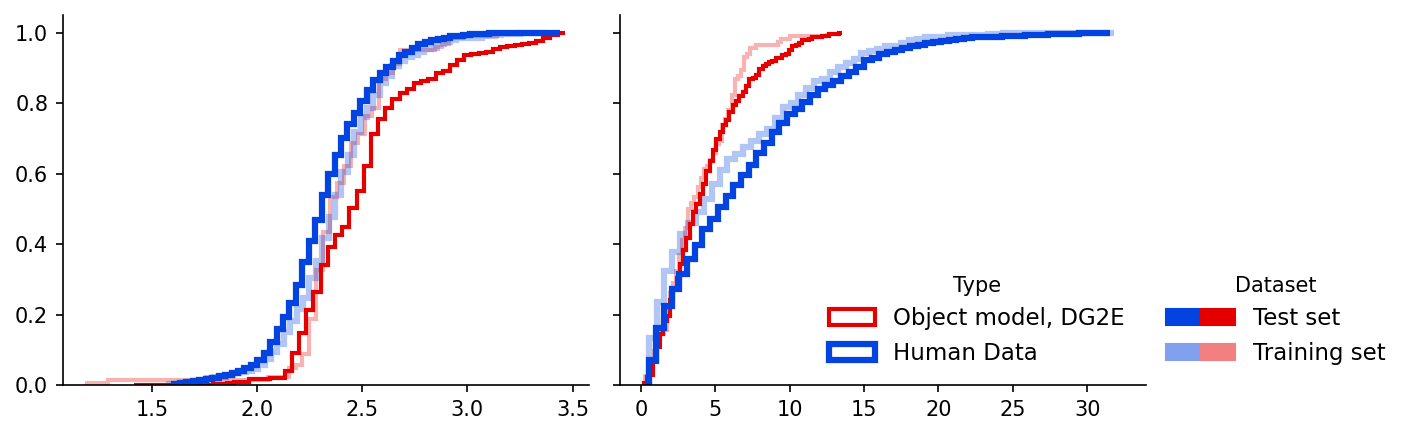

In [86]:
handles1 = []; handles2 = []
for ind in range(len(mcl)):
    rgb = to_rgb(mcl[ind])
    handles1.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    handles2.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))

fig, axs = plt.subplots(1,2,dpi=150, figsize=(9.5,3), sharey=True)

for modus in ["train", "test"]:
    if modus == "train":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        alpha = 0.3
        idx = 1      # Training = less intensive color
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        alpha = 1.0
        idx = 0      # Test = more intensive color

    gt_amp_dva = gt_amp_dva[gt_amp_dva > 0.5]

    df_res_object_DG2E_cb_top0 = pd.read_csv(f'results/{simulate_with_best_params}_0.csv.gz', compression='gzip')
    df_res_object_DG2E_cb_top0 = df_res_object_DG2E_cb_top0[df_res_object_DG2E_cb_top0['video'].isin(videoset)]
    obj_hlf_dur_ms = df_res_object_DG2E_cb_top0["duration_ms"].dropna().values 
    obj_hlf_amp_dva = df_res_object_DG2E_cb_top0["sac_amp_dva"].dropna().values 

    nbins = 60

    label_human = 'Human Data' if modus == 'test' else None
    label_model = 'Object model, DG2E' if modus == 'test' else None

    axs[0].hist(np.log10(obj_hlf_dur_ms), nbins, density=True, histtype='step',
                cumulative=True, label=label_model,
                color=mcl[1], lw=2, alpha=alpha)

    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step',
                cumulative=True, label=label_human,
                color=mcl[0], lw=3, alpha=alpha)

    axs[1].hist(obj_hlf_amp_dva, nbins, density=True, histtype='step',
                cumulative=True, label=label_model,
                color=mcl[1], lw=2, alpha=alpha)

    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step',
                cumulative=True, label=label_human,
                color=mcl[0], lw=3, alpha=alpha)

    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])

# 1. Legende: Human vs. Model 
leg1 = axs[1].legend(loc='lower right', frameon=False, title="Type", fontsize=11)

# 2. Legende: Train vs. Test 
leg2 = axs[1].legend(bbox_to_anchor=(1,0), loc='lower left',
                     frameon=False,
                     handles=[tuple(handles1), tuple(handles2)],
                     labels=["Test set", "Training set"],
                     title="Dataset",
                     handlelength=3,
                     handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
                     fontsize=11)

axs[1].add_artist(leg1)  # both legends visible
sns.despine(fig); fig.tight_layout()
